## Load Data

In [23]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import tensorflow as tf
import glob
from scipy import interpolate
from collections import Counter
import os
from itertools import product

plt.style.use("dark_background")

types_vocab = ["EXP", "HIB", "LP", "PIS", "TOR", "TR", "VT"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
try:
    table = pd.read_pickle("data/table.pkl")
except:
    table = pd.read_excel("data/association_table_corrected_index.xlsx")


In [3]:
table.head()


,Index,Event,Duration,Event start,Event stop,File name,File start,File end,Sampling rate,Overlap,Unnamed: 10,Unnamed: 11,Unnamed: 12,npts,energy,path
0,0,LP1,33,2006-05-23 20:39:27.060000+00:00,2006-05-23 20:40:00.060000+00:00,20060523_2033.UB1.SL.Z.sac,2006-05-23 20:33:05.895000+00:00,2006-05-23 20:43:05.885000+00:00,100.0,False,NaN,NaN,NaN,60000.0,0.24403,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...
1,1,LP1,45,2006-05-23 20:39:59.960000+00:00,2006-05-23 20:40:44.960000+00:00,20060523_2033.UB1.SL.Z.sac,2006-05-23 20:33:05.895000+00:00,2006-05-23 20:43:05.885000+00:00,100.0,False,NaN,NaN,NaN,60000.0,0.11833,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...
2,2,TR2,128,2006-05-23 22:37:52.910000+00:00,2006-05-23 22:40:00.910000+00:00,20060523_2235.UB1.SL.Z.sac,2006-05-23 22:35:19.895000+00:00,2006-05-23 23:05:19.875000+00:00,50.0,False,NaN,NaN,NaN,90000.0,0.79052,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...
3,3,LP1,32,2006-05-23 22:44:09.410000+00:00,2006-05-23 22:44:41.410000+00:00,20060523_2235.UB1.SL.Z.sac,2006-05-23 22:35:19.895000+00:00,2006-05-23 23:05:19.875000+00:00,50.0,False,NaN,NaN,NaN,90000.0,1.15570,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...
4,4,TR2,78,2006-05-23 22:46:58.440000+00:00,2006-05-23 22:48:16.440000+00:00,20060523_2245.UB1.SL.Z.sac,2006-05-23 22:45:19.895000+00:00,2006-05-23 22:55:19.885000+00:00,100.0,False,NaN,NaN,NaN,60000.0,0.23330,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...


In [4]:
if not os.path.isfile("data/table.pkl"):
    table.to_pickle("data/table.pkl")


## Make list of spectrograms

In [5]:
table.Event.value_counts().min()


67

In [87]:
TRAIN_SIZE = 80
TEST_SIZE = 20


In [88]:
T_MAX = 60
F_MAX = 20

t_itp = np.linspace(0, T_MAX, 25)
f_itp = np.linspace(0, F_MAX, 25)


In [89]:
dict_interps = dict()
counter = Counter()
list_interps = []
list_types = []


In [90]:
# shuffle the dataframe
table = table.sample(frac=1)


In [91]:
# ts = np.load(f"data/Extracted/EXP/EXP_128.npy")
# f, t, S = signal.spectrogram(ts, row["Sampling rate"])
# func = interpolate.RectBivariateSpline(f, t, S)
# plt.imshow(S)

In [92]:
for index, row in table.iterrows():
    event = row["Event"]
    event_type = event if event in types_vocab else event[:-1]
    if counter[event_type] >= TRAIN_SIZE + TEST_SIZE:
        continue
    name = event_type + "_" + str(row["Index"])
    filename = name + ".npy"
    try:
        ts = np.load(f"data/Extracted/{event_type}/{filename}")
        f, t, S = signal.spectrogram(ts, row["Sampling rate"])
        func = interpolate.RectBivariateSpline(f, t, S)
        # func = interpolate.interp2d(f,t,S, fill_value = 0)
    except:
        continue
    S_int = func(f_itp, t_itp)
    for (i, f_i), (j, t_j) in product(enumerate(f_itp),enumerate(t_itp)):
        if f_i > f.max() or t_j > t.max():
            S_int[i,j] = 0
    # dict_interps[name] = S_int
    list_interps.append(S_int)
    list_types.append(event_type)
    counter[event_type] += 1


In [93]:
len(list_interps)


698

In [94]:
Counter(list_types)


Counter({'LP': 100,
         'TR': 100,
         'HIB': 100,
         'PIS': 100,
         'TOR': 98,
         'VT': 100,
         'EXP': 100})

In [95]:
# np.savez("./dataset_spectro", **dict_interps)

## Datasets

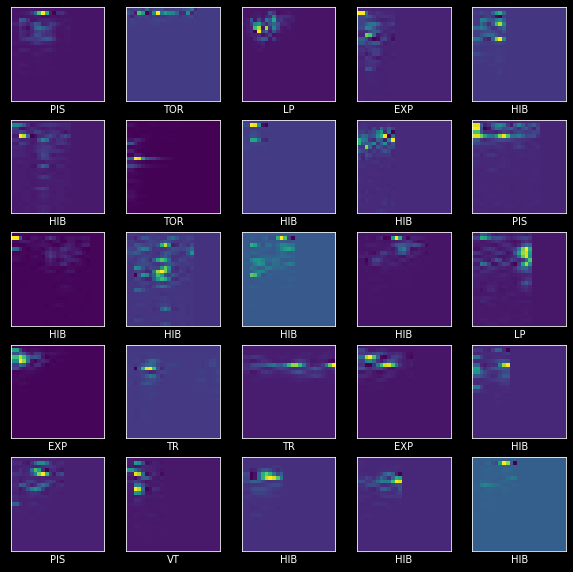

In [96]:
plt.figure(figsize=(10,10))
perm = np.random.permutation(len(list_interps))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(list_interps[perm[i]])
    plt.xlabel(list_types[perm[i]])
plt.show()

In [97]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
list_types_num = le.fit_transform(list_types)


In [98]:
# dataset = tf.data.Dataset.from_tensor_slices((list_interps, list_types_num))
# dataset

In [99]:
dataset = tf.data.Dataset.from_tensor_slices((list_interps, list_types_num))
dataset = dataset.shuffle(TEST_SIZE + TRAIN_SIZE)
test_dataset = dataset.take(TEST_SIZE)
train_dataset = dataset.skip(TEST_SIZE)
test_dataset = test_dataset.batch(1)
train_dataset = train_dataset.batch(1)
# train_dataset = tf.data.Dataset.from_tensor_slices((list_interps[:20], list_types[:20]))
# test_dataset = tf.data.Dataset.from_tensor_slices((list_interps[20:], list_types[20:]))

In [100]:
test_dataset

<BatchDataset shapes: ((None, 25, 25), (None,)), types: (tf.float64, tf.int64)>

/tmp/ipykernel_17797/1936445080.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_itp, f_itp, list_interps[8])


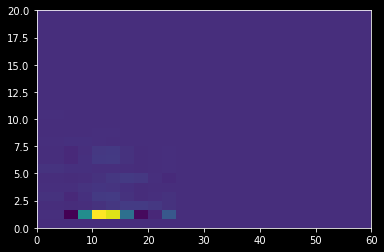

In [101]:
plt.pcolormesh(t_itp, f_itp, list_interps[8])

In [102]:
from tensorflow.keras import datasets, layers, models

In [111]:
dropout_rate = 0.1

model = models.Sequential()
model.add(layers.Reshape((25, 25, 1), input_shape=(25, 25)))
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(25, 25, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(7))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 25, 25, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 23, 23, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 9, 9, 64)          18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 2, 2, 32)          18464     
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)              

In [115]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [116]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="accuracy", patience=10, restore_best_weights=True
)

In [117]:
history = model.fit(train_dataset, epochs=50, callbacks=[early_stopping])

Epoch 1/50
678/678 [==============================] - 3s 3ms/step - loss: 18124.1699 - accuracy: 0.3215
Epoch 2/50
678/678 [==============================] - 2s 3ms/step - loss: 10249.2734 - accuracy: 0.2493
Epoch 3/50
678/678 [==============================] - 2s 3ms/step - loss: 8860.5391 - accuracy: 0.2640
Epoch 4/50
678/678 [==============================] - 2s 3ms/step - loss: 3214.9336 - accuracy: 0.2950
Epoch 5/50
678/678 [==============================] - 2s 3ms/step - loss: 1065.2024 - accuracy: 0.2537
Epoch 6/50
678/678 [==============================] - 2s 3ms/step - loss: 768.5020 - accuracy: 0.2316
Epoch 7/50
678/678 [==============================] - 2s 3ms/step - loss: 240.1417 - accuracy: 0.2935
Epoch 8/50
678/678 [==============================] - 2s 3ms/step - loss: 2146.1196 - accuracy: 0.2537
Epoch 9/50
678/678 [==============================] - 2s 3ms/step - loss: 2247.6265 - accuracy: 0.2301
Epoch 10/50
678/678 [==============================] - 2s 3ms/step - loss

In [107]:
model.evaluate(test_dataset)

20/20 [==============================] - 0s 2ms/step - loss: 796.1033 - accuracy: 0.1000


[796.1033325195312, 0.10000000149011612]